## P1 - 請作出大學部同學在必修、選修、通識這三類課程的不分系histogram

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

sns.set(style='darkgrid', font='Microsoft JhengHei')

In [2]:
data_list = glob.glob("data/10*.csv")
df = pd.concat([pd.read_csv(data_file) for data_file in data_list])

info_list = glob.glob("data/basic_info*.csv")
info_df = pd.concat([pd.read_csv(data_file) for data_file in info_list])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
# only select undergraduated student
undergraduate_info = info_df[~(info_df["歸屬系所"].str.contains("碩士班") | info_df["歸屬系所"].str.contains("在職專班") | info_df["歸屬系所"].str.contains("博士班"))]

In [4]:
# use inner join to filter data to get the scores of undergraduated students
# 原理 -> inner join的merge可以找到兩者 "on" 的交集。
# 因此上方我已經做了undergraduate的filter，就可以再利用 "on" 學號去找到大學生的成績
inner_merged_undergraduate_data = pd.merge(df, undergraduate_info, left_on="學號", right_on="去識別化學號")

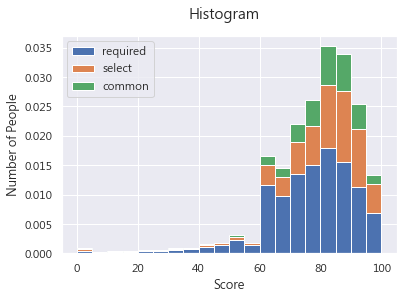

In [5]:
inner_merged_undergraduate_data['課程屬性'] = inner_merged_undergraduate_data['課程屬性'].apply(lambda string : string.strip())
inner_merged_undergraduate_data.dropna(subset=["成績"], inplace=True)
required = inner_merged_undergraduate_data[inner_merged_undergraduate_data['課程屬性']=='必修']
select = inner_merged_undergraduate_data[inner_merged_undergraduate_data['課程屬性']=='選修']
common = inner_merged_undergraduate_data[inner_merged_undergraduate_data['課程屬性']=='通識']
physical = inner_merged_undergraduate_data[inner_merged_undergraduate_data['課程屬性']=='體育']

plt.hist([required["成績"], select["成績"], common["成績"]], bins=20, label=["required", "select", "common"], stacked=True, density=True)
plt.xlabel("Score")
plt.ylabel("Number of People")
plt.suptitle('Histogram')
plt.legend()
plt.show()


## P2 (P1 Discussion) 請問從這些分數的分佈來看，上述三類課程的給分是否有奇特之處？

bins=20 means that the range of bar is 5. 每個bar代表著五分的級距
在這三者中都有著差不多的分佈，在這兩種課程中的學生大多都在80分以上。
但是在必修課中，各個級距的人數看起來非常接近，且在60分那邊反而是增加的。
這告訴我們，可能很多人本來都是低於60分，但被老師救到低空飛過

## P3 再從每一門課的成績來看，你能找出那些課的給分很不合理嗎？

In [6]:
# 根據題意，我認為可以使用離群值分析及尋找極端值來處理。若資料超出 Q1 - 1.5 * IQR 到 Q3 + 1.5 * IQR 這個範圍，就有可能是有問題的資料。

In [7]:
medians = inner_merged_undergraduate_data.groupby("課名")["成績"].median().sort_values()
print(medians)
#從這個medians可以知道竟然有些資料中位數竟然是0分，以此可知，有些資料根本本身就是dirty的。因此，我們應該先濾除這些0分的資料。
#有些則是100分獲高於95分，那那些可能是只有一人的專題研究。
#總之，先濾除0分，再看看這些是否已經離群，再做判定。

課名
室內技術設計A            0.0
材料熱力學(二)           0.0
系統晶片設計實驗           0.0
法國小說3              0.0
微觀經濟學              0.0
                 ...  
物聯網系統設計與應用        99.0
熱力學(一)            99.0
不動產市場專題           99.5
當代重力及高能物理研究II    100.0
進階流體力學           100.0
Name: 成績, Length: 3795, dtype: float64


In [8]:
medians_with_index = inner_merged_undergraduate_data.groupby("課名")["成績"].median().reset_index()
sorted_median_with_index = medians_with_index[~(medians_with_index["成績"] == 0)].sort_values("成績")
print(sorted_median_with_index) #list and verify data

                 課名     成績
1438      感知無線電通訊實驗   13.5
2144      清末民初的中國佛教   20.0
3189     象徵主義藝術專題研究   24.0
1474         應用量子力學   30.0
1094           實驗設計   37.5
...             ...    ...
2259     物聯網系統設計與應用   99.0
2098     海嘯與波浪動力學概論   99.0
64          不動產市場專題   99.5
2492  當代重力及高能物理研究II  100.0
3384         進階流體力學  100.0

[3789 rows x 2 columns]


In [9]:
median_of_medians = sorted_median_with_index.median()
print(median_of_medians["成績"])
Q1 = sorted_median_with_index["成績"].quantile(0.25)
Q3 = sorted_median_with_index["成績"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
higher_bound =  Q3 + 1.5 *IQR
print(Q1, Q3, IQR, lower_bound, higher_bound)
#到這邊我發現higher bound，也就是離群的最高值，竟然超過100，或許是中央大學的老師給分都太甜? 或者是上面曾經提過的，有很多課堂都是開給一兩個人的專題，若是那些分數也放入參考，再加上如果這個數量很大的話，將會影響整個資料群的分布區域。因此應該進一步先討論是否中位數超過95或者超過90以上就應該列為評分不合理?

85.0
80.0 89.0 9.0 66.5 102.5


In [10]:
#這個Block將進一步濾除higher bound跟lower bound之外的數值。
make_sense_data = sorted_median_with_index[(sorted_median_with_index["成績"] >= lower_bound) & (sorted_median_with_index["成績"] <= higher_bound)]
print(make_sense_data)
make_no_sense_data = sorted_median_with_index[~((sorted_median_with_index["成績"] >= lower_bound) & (sorted_median_with_index["成績"] <= higher_bound))]
print(make_no_sense_data) #依照這個資料集，這些資料可能都是給分太低的。

                 課名     成績
906          天文觀測 I   66.5
3383         進階法語視聽   66.5
1278       工程數學  II   67.0
811         基礎工程光學I   67.0
2208         熱流導論II   67.0
...             ...    ...
2259     物聯網系統設計與應用   99.0
2098     海嘯與波浪動力學概論   99.0
64          不動產市場專題   99.5
2492  當代重力及高能物理研究II  100.0
3384         進階流體力學  100.0

[3711 rows x 2 columns]
              課名    成績
1438   感知無線電通訊實驗  13.5
2144   清末民初的中國佛教  20.0
3189  象徵主義藝術專題研究  24.0
1474      應用量子力學  30.0
1094        實驗設計  37.5
...          ...   ...
441          動力學  66.0
2209         熱物理  66.0
2607      科技英文寫作  66.0
992         孫子兵法  66.0
3655      音樂鑑賞導引  66.0

[78 rows x 2 columns]


In [11]:
#也可以從average的角度來看，因為如果原本的資料群已經不是常態分布，看中位數似乎有機會沒有辦法那麼精確地看出資料群的位置。
mean_with_index = inner_merged_undergraduate_data.groupby("課名")["成績"].mean().reset_index()
sorted_mean_with_index = mean_with_index[~(medians_with_index["成績"] == 0)].sort_values("成績")
print(sorted_mean_with_index) #list and verify data

                 課名     成績
2144      清末民初的中國佛教   20.0
3189     象徵主義藝術專題研究   24.0
1438      感知無線電通訊實驗   29.5
1474         應用量子力學   30.0
1094           實驗設計   37.5
...             ...    ...
2098     海嘯與波浪動力學概論   99.0
2196         熱力學(一)   99.0
64          不動產市場專題   99.5
3384         進階流體力學  100.0
2492  當代重力及高能物理研究II  100.0

[3789 rows x 2 columns]


In [12]:
median_of_means = sorted_mean_with_index.median()
print(median_of_means["成績"])
Q1 = sorted_mean_with_index["成績"].quantile(0.25)
Q3 = sorted_mean_with_index["成績"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
higher_bound =  Q3 + 1.5 *IQR
print(Q1, Q3, IQR, lower_bound, higher_bound)
#這邊的higher bound，也超過100。

83.15957446808511
78.0 87.84615384615384 9.84615384615384 63.23076923076924 102.6153846153846


In [13]:
#這個Block將進一步濾除higher bound跟lower bound之外的數值。
make_sense_data_mean = sorted_mean_with_index[(sorted_mean_with_index["成績"] >= lower_bound) & (sorted_mean_with_index["成績"] <= higher_bound)]
print(make_sense_data_mean)
make_no_sense_data_mean = sorted_mean_with_index[~((sorted_mean_with_index["成績"] >= lower_bound) & (sorted_mean_with_index["成績"] <= higher_bound))]
print(make_no_sense_data_mean) #依照這個資料集，這些資料可能都是給分太低的。

                 課名          成績
298             光學Ｉ   63.259740
1758         普通天文學Ⅰ   63.315789
1463          應用機率Ⅰ   63.477612
151            交通控制   63.500000
3638        靜力與材料力學   63.516129
...             ...         ...
2098     海嘯與波浪動力學概論   99.000000
2196         熱力學(一)   99.000000
64          不動產市場專題   99.500000
3384         進階流體力學  100.000000
2492  當代重力及高能物理研究II  100.000000

[3722 rows x 2 columns]
              課名         成績
2144   清末民初的中國佛教  20.000000
3189  象徵主義藝術專題研究  24.000000
1438   感知無線電通訊實驗  29.500000
1474      應用量子力學  30.000000
1094        實驗設計  37.500000
...          ...        ...
2512       相對論導論  62.567901
3688       高溫變形學  62.793893
250      傳統武術(棍)  63.000000
3594        電磁學Ⅰ  63.103734
814         基礎數學  63.145244

[67 rows x 2 columns]


## P4 必修、選修、通識和體育成績之間有相關嗎？


                                     學號   required
0      00063e3c07ae571fc37e0ac5dd431963  76.500000
1      00088cb1f8e9054360937598890d7e7b  73.756757
2      0008f3da62d75a85478203873f9be227  82.333333
3      000b3a65ceb2fcfff186ec7005d8c7f1  81.200000
4      000c80387f0ae563dcbcaf5362674122  81.166667
...                                 ...        ...
19678  fff3d6fe0d09ab47aeb8e7a4b644b39d  84.500000
19679  fffafcc59e1a60006b08379f87c07f4b  85.363636
19680  fffd03972845acd6f2e2b43f05636502  88.562500
19681  fffebf404c803261d4859affd0b1f266  75.066667
19682  ffff0eace935076556e3f740f41f5b10  90.666667

[19683 rows x 2 columns]
                                     學號     select
0      00063e3c07ae571fc37e0ac5dd431963  78.700000
1      00088cb1f8e9054360937598890d7e7b  70.722222
2      0008f3da62d75a85478203873f9be227  86.777778
3      000b3a65ceb2fcfff186ec7005d8c7f1  88.272727
4      000c80387f0ae563dcbcaf5362674122  77.500000
...                                 ...        ...
19763

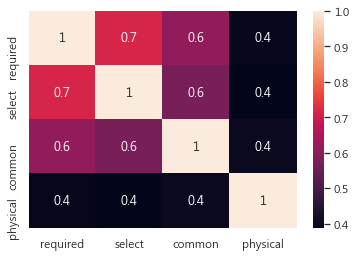

In [14]:
# 畫一個Heatmap能最快的達成效果。

required_mean = required.groupby("學號")["成績"].mean().reset_index().rename({"成績":"required"}, axis=1)
select_mean = select.groupby("學號")["成績"].mean().reset_index().rename({"成績":"select"}, axis=1)
common_mean = common.groupby("學號")["成績"].mean().reset_index().rename({"成績":"common"}, axis=1)
physical_mean = physical.groupby("學號")["成績"].mean().reset_index().rename({"成績":"physical"}, axis=1)
print(required_mean)
print(select_mean)
print(common_mean)
print(physical_mean)
heat_data = pd.merge(required_mean, select_mean, on="學號")
heat_data = pd.merge(heat_data, common_mean, on="學號")
heat_data = pd.merge(heat_data, physical_mean, on="學號")
heat_data.drop(columns=["學號"], inplace=True)
print(heat_data)
sns_heatmap = sns.heatmap(heat_data.corr(), annot = True, fmt='.1g')
fig = sns_heatmap.get_figure()
fig.show()